Plot wind stress, bathymetry, mesoscale-resolving

In [1]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm
from matplotlib.ticker import LogFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [2]:
root = '/scratch/mp6191/NW2_TracerBackscatter'

# Hi-res static
static = xr.open_dataset(root + '/p03125_2' + '/static.nc', decode_times = False)
grid = Grid(static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                     'Y': {'center': 'yh', 'outer': 'yq'}}, periodic = ['X'])
dx = grid.interp(static.dxCu, axis = 'X')
dy = grid.interp(static.dyCv, axis = 'Y')

# Ld = c_1 / \sqrt(f_0^2 + 2 \beta c_1)
Rd = xr.open_mfdataset(root + '/p5_noBS_KHTR2400Var/snapshots*.nc', decode_times = False).Rd1.isel(time = -1).interp_like(static.area_t)

# Ld / \sqrt((dx^2 + dy^2)/2)
Rd_dx = Rd / np.sqrt((dx ** 2 + dy ** 2) / 2)
Rd_dx = Rd_dx.coarsen(xh = 32, yh = 32, boundary = 'exact').mean().interp_like(static.area_t)

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [3]:
# From Nora Loose
def scurve(x, x0, dx):
    """Returns 0 for x<x0 or x>x+dx, and a cubic in between."""
    s = np.minimum(1, np.maximum(0, (x-x0)/dx))
    return (3 - 2*s) * (s*s)
    
def tau_profile(ytau, taud, ys):
    """Returns wind profile that uses s-curves between (node, value) = (y, tau)"""
    taus = 0. * ys
    ks = 0
    for i in range(len(ys)):
        y = ys[i]
        if y >= ytau[ks+1]:
            ks = min(len(ytau)-2, ks+1)
        taus[i] = taud[ks] + (taud[ks+1] - taud[ks]) * scurve(y, ytau[ks], ytau[ks+1] - ytau[ks])
    return taus

#NW2 wind profile
y, tau = [-70, -45, -15, 0, 15, 45, 70], [0, 0.2, -0.1, -0.02, -0.1, 0.1, 0]
ys = np.linspace(-70,70,500)
profile = tau_profile(y, tau, ys)

### Plot

/state/partition1/job-64551423/ipykernel_803468/2374350630.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', nr_levels)


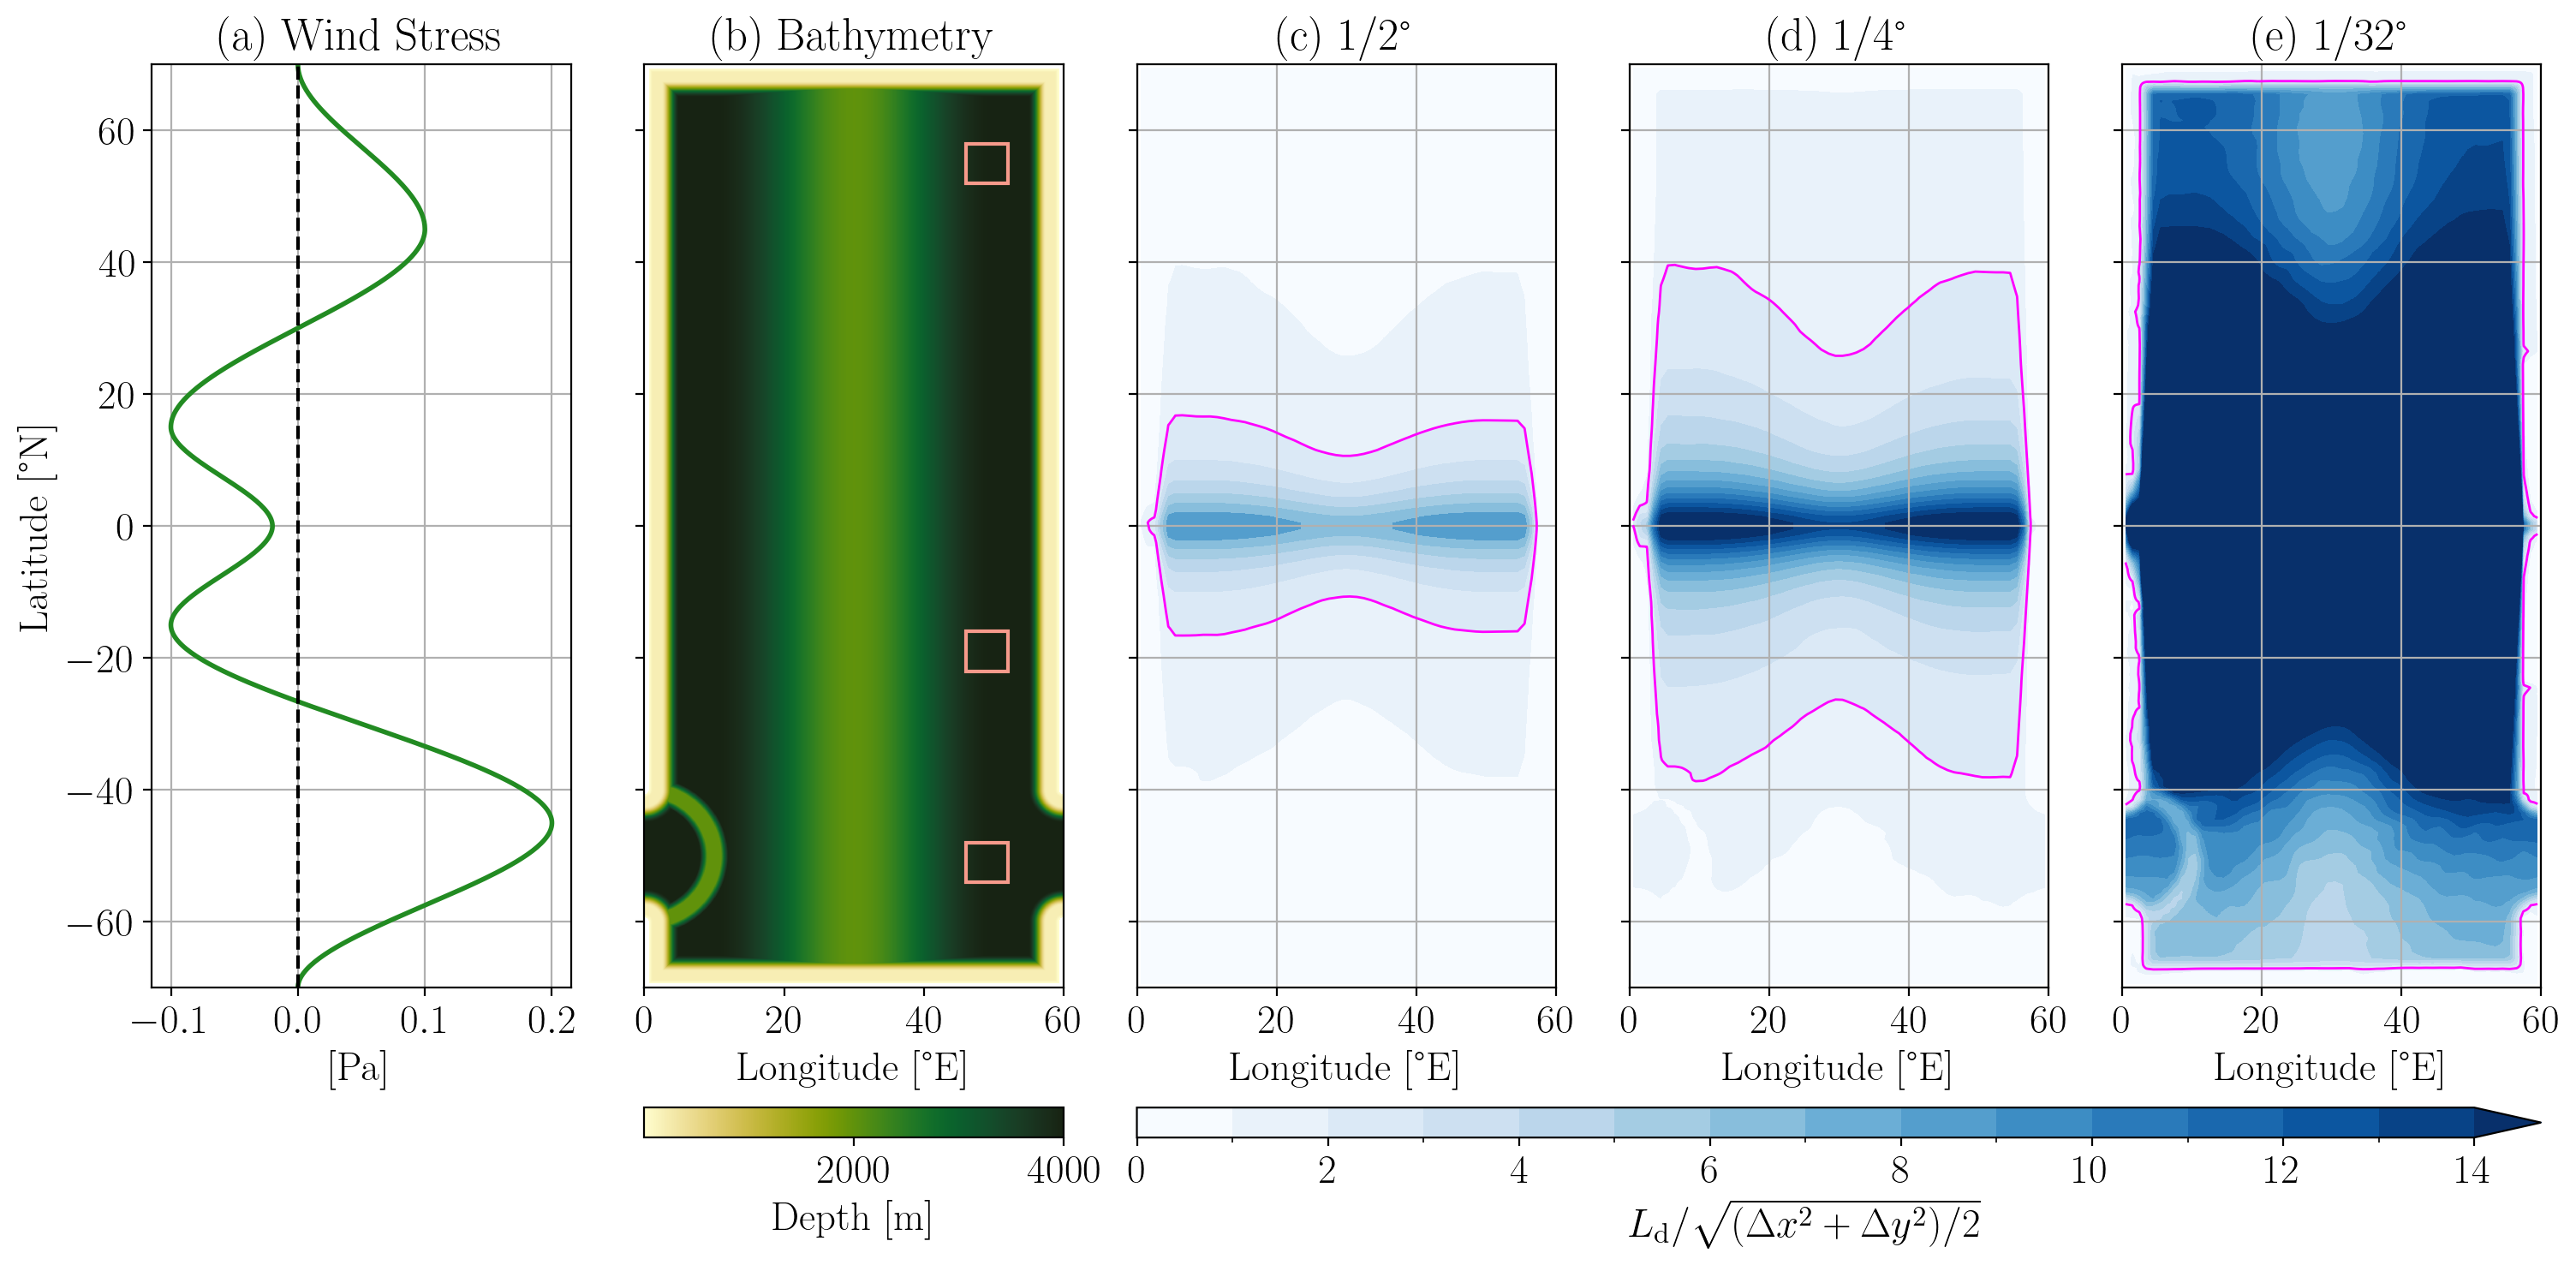

In [4]:
##### Create figure and GridSpec
fig = plt.figure(figsize = (18, 7), dpi = 200)
fontsize = 19
gs = gridspec.GridSpec(1, 5, figure = fig, wspace = 0.175)

# Create axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])

cbar_shift = 0.125
cbar_height = 0.025

### Plot
# (a)
ax = ax1
color = 'forestgreen' #'olivedrab'
ax.plot(profile, ys, linewidth=2, color = color)
ax.axvline(0, linestyle = 'dashed', color = 'k')
ax.grid()
ax.set_ylabel('Latitude [°N]', fontsize = fontsize - 2)
ax.set_xlabel('[Pa]', fontsize = fontsize - 2)
ax.set_title('(a) Wind Stress', fontsize = fontsize)
ax.set_xticks(np.linspace(-0.1, 0.2, 4))
ax.set_yticks(np.linspace(-60, 60, 7))
ax.set_ylim([static.depth_ocean.yh[0], static.depth_ocean.yh[-1]])
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

# (b)
ax = ax2
im = static.depth_ocean.plot(ax = ax, cmap = cmocean.cm.speed, add_colorbar = False)
# Vertical structure regions
color = '#f69a8b' #'#b91a38' #'blueviolet' # 'fuchsia'
ax.add_patch(patches.Rectangle((46, -22), 6, 6, edgecolor = color, facecolor = 'none', linewidth = 1.5)) # subtropics
ax.add_patch(patches.Rectangle((46, 52), 6, 6, edgecolor = color, facecolor = 'none', linewidth = 1.5)) # subpolar
ax.add_patch(patches.Rectangle((46, -54), 6, 6, edgecolor = color, facecolor = 'none', linewidth = 1.5)) # ACC

ax.set_ylabel('', fontsize = fontsize)
ax.set_yticks(np.linspace(-60, 60, 7))
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_title('(b) Bathymetry', fontsize = fontsize)
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

pos2 = ax2.get_position()
cbar_ax2 = fig.add_axes([
    pos2.x0,
    pos2.y0 - cbar_shift,
    pos2.width,
    cbar_height])
cbar = fig.colorbar(im, cax = cbar_ax2, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = fontsize - 2)
cbar.set_label('Depth [m]', fontsize = fontsize - 2)
# (c)--(e)
nr_levels = 15
levels = np.linspace(0, nr_levels - 1, nr_levels)
cmap = cm.get_cmap('Blues', nr_levels)
color = 'fuchsia'
linewidth = 1 # 0.5
alpha = 1 #0.25

ax = ax3
factor = 32 / 2
(Rd_dx / factor).plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
ax.contour(static.xh, static.yh, Rd_dx / factor, levels = [2], colors = (color), linestyles = ('-',), linewidths = (linewidth,), alpha = alpha)
ax.set_ylabel('', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_title('(c) 1/2°', fontsize = fontsize)
ax.set_yticks(np.linspace(-60, 60, 7))
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.grid()

ax = ax4
factor = 32 / 4
(Rd_dx / factor).plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
ax.contour(static.xh, static.yh, Rd_dx / factor, levels = [2], colors = (color), linestyles = ('-',), linewidths = (linewidth,), alpha = alpha)
ax.set_ylabel('', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_title('(d) 1/4°', fontsize = fontsize)
ax.set_yticks(np.linspace(-60, 60, 7))
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.grid()

ax = ax5
factor = 32 / 32
im = (Rd_dx / factor).plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
ax.contour(static.xh, static.yh, Rd_dx / factor, levels = [2], colors = (color), linestyles = ('-',), linewidths = (linewidth,), alpha = alpha)
ax.set_ylabel('', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_title('(e) 1/32°', fontsize = fontsize)
ax.set_yticks(np.linspace(-60, 60, 7))
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.grid()

# Horizontal colorbar
pos3 = ax3.get_position()
pos5 = ax5.get_position()
cbar_ax_shared = fig.add_axes([
    pos3.x0,
    pos5.y0 - cbar_shift,  # shift downward
    pos5.x1 - pos3.x0,  # full width from ax3 to ax5
    cbar_height])
cbar = fig.colorbar(im, cax = cbar_ax_shared, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = fontsize - 2)
cbar.set_label(r'$L_{\mathrm{d}} / \sqrt{(\Delta x^2 + \Delta y^2)/2}$', fontsize = fontsize - 2)

plt.savefig('Fig_NW2_config.png', bbox_inches = 'tight', dpi = 300)